In [2]:
import numpy as np
import timeit
import sklearn.metrics
from sklearn.metrics import mean_squared_error

from scipy import sparse
from cvxpy import *
import gurobipy
import matplotlib.pyplot as plt
% matplotlib inline

def create_matrix(kernel, image_size):
    k = kernel.shape[0]
    tmp = np.zeros((image_size**2, image_size-k+1))
    tmp1 = np.zeros((image_size**2))
    for i in range(k):
        tmp1[i*image_size:i*image_size + k] += kernel[i]
    tmp[:,0] += tmp1
    for i in range(1, image_size-k+1):
        tmp[i:,i] += tmp1[:-i]
    tmp = tmp.T
    k = kernel.shape[0]
    final = sparse.csr_matrix(tmp)
    tmp = sparse.csr_matrix(tmp)
    for i in range(1, image_size-k+1):
        sparse_zeros = sparse.csr_matrix(np.zeros((image_size-k+1, image_size*i)))
        sparse_tmp = sparse.csr_matrix(sparse.hstack((sparse_zeros, tmp[:,:-image_size*i])))
        final = sparse.vstack((final, sparse_tmp))
    return final



def create_gaussian_kernel(bound, size):
    t = np.linspace(-bound, bound, size)
    bump = np.exp(-0.1*t**2)
    kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
    kernel = kernel/kernel.sum()
    return kernel


We have a following optimization problem:
        $$y = argmin \frac{1}{2 \sigma}(||z - Ay ||_2^2) + \tau p(y), $$
where $$z = Ay + \sigma \varepsilon, $$ 

$z, t \in \mathbb{R}^N$, $z$ - observed image, $y$ - true image we are trying to find, $A$ - $N \times N$ blur matrix, $\varepsilon \sim N(0, I)$, $\sigma$ - standard deviation of noise, $\tau > 0$ - regalarization parameter, $p(y)$ - penalty. 

For all methods different kinds of penalty is used: 
- $p(y) = || y ||_1$
- $p(y) = || y ||_2$


In [16]:
def blurring(img, kernel_size, kernel_bound):
    kernel = create_gaussian_kernel(kernel_bound, kernel_size)
    A = create_matrix(kernel, img.shape[0])

    new_img = A@img.reshape((img.shape[0]**2), img.shape[2])
    new_size = int(np.sqrt(new_img.shape[0]))
    blurred_img = new_img.reshape((new_size,new_size, img.shape[2]))
    
    
    blurred_with_noise = blurred_img + sigma*np.append(np.random.randn(blurred_img.shape[0],blurred_img.shape[1], 3), 
    np.zeros((blurred_img.shape[0],blurred_img.shape[1],1)), axis = 2)
    
    z = blurred_with_noise.reshape((blurred_with_noise.shape[0]**2), blurred_with_noise.shape[2])
    
    return blurred_with_noise, z, A

In [17]:
def deblurring_with_cvxpy(img, z, A,tau_value, norm_value, solver = 'GUROBI'):        
    
    y = Variable(img.shape[0]**2, img.shape[2]-1)
    tau = Parameter(sign='positive', value = tau_value)

    constraints = []
    constraints.append(y >= 0) 
    constraints.append(y <= 1)    

    obj1  = (1.0/sigma*2.0)*(norm(z[:,:3]-(A)*y, 'fro'))**2
    obj = Minimize(obj1 + tau*norm(y, norm_value))

    prob = Problem(obj, constraints)    
        
    time_start = timeit.default_timer()

    prob.solve(solver)

    time_end = timeit.default_timer()
    time_solve = time_end - time_start
    
    print ("status:", prob.status)
   
    
    deblurred_img = np.array(y.value)
    error = mean_squared_error(img[:,:,:3].reshape((img.shape[0]**2), img[:,:,:3].shape[2]), deblurred_img)
    
    new_size = int(np.sqrt(deblurred_img.shape[0]))  
    deblurred_img = deblurred_img.reshape((new_size,new_size, deblurred_img.shape[1]))
    
    
    
    return deblurred_img, error, time_solve, prob.value


In [18]:
sigma = 1e-3

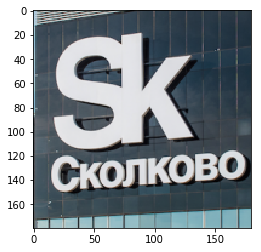

In [19]:
img_Sk_tiny = plt.imread('skolkovo_tiny.png')

plt.figure()
plt.imshow(img_Sk_tiny)

In [22]:
time_Sk_norm1 = []
error_Sk_norm1 = []
loss_Sk_norm1 = []

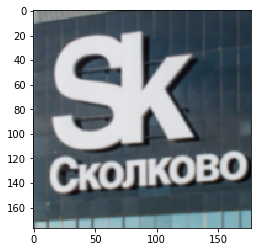

In [25]:
blurred_img, z, A = blurring(img_Sk_tiny, 4, 4)
plt.figure()
plt.imshow(blurred_img)
plt.imsave("Sk_blur_44.png", blurred_img)

status: optimal
error 0.0207725625355
time 4.062599612529448 min


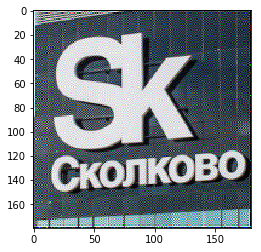

In [26]:
deblurred_img, error_img, time_img , loss_img = \
            deblurring_with_cvxpy(img_Sk_tiny, z, A,norm_value = 1, tau_value = 1e-3)

error_Sk_norm1.append(error_img)
time_Sk_norm1.append(time_img/60.0)
loss_Sk_norm1.append(loss_img)

plt.figure()
print('error', error_img)
print('time', time_img/60.0, 'min')

plt.imshow(np.clip(deblurred_img, 0, 1))
plt.imsave("Sk_deblur_44_norm1.png", np.clip(deblurred_img, 0, 1))

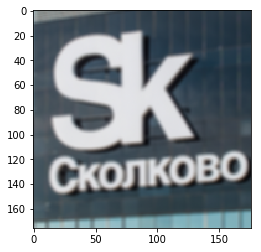

In [27]:
blurred_img, z, A = blurring(img_Sk_tiny, 5, 3)

plt.figure()
plt.imshow(blurred_img)
plt.imsave("Sk_blur_35.png", blurred_img)

status: optimal
error 0.0372568239303
time 5.337200934855908 min


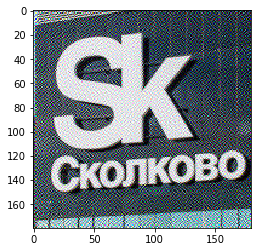

In [28]:
deblurred_img, error_img, time_img , loss_img = \
            deblurring_with_cvxpy(img_Sk_tiny, z, A,norm_value = 1, tau_value = 1e-3)

error_Sk_norm1.append(error_img)
time_Sk_norm1.append(time_img/60.0)
loss_Sk_norm1.append(loss_img)

plt.figure()
print('error', error_img)
print('time', time_img/60.0, 'min')

plt.imshow(np.clip(deblurred_img, 0, 1))
plt.imsave("Sk_deblur_35_norm1.png", np.clip(deblurred_img, 0, 1))

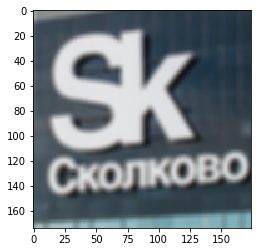

In [20]:
blurred_img, z, A = blurring(img_Sk_tiny, 7, 3)

plt.figure()
plt.imshow(np.clip(blurred_img, 0, 1))
plt.imsave("Sk_37_blur.png", np.clip(blurred_img, 0, 1))

status: optimal
error 0.0519662398119
time 10.270091949589574 min


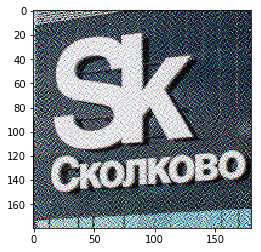

In [23]:
deblurred_img, error_img, time_img , loss_img = \
            deblurring_with_cvxpy(img_Sk_tiny, z, A,norm_value = 1, tau_value = 1e-3)

error_Sk_norm1.append(error_img)
time_Sk_norm1.append(time_img/60.0)
loss_Sk_norm1.append(loss_img)

plt.figure()
print('error', error_img)
print('time', time_img/60.0, 'min')

plt.imshow(np.clip(deblurred_img, 0, 1))
plt.imsave("Sk_37_deblur_norm1.png", np.clip(deblurred_img, 0, 1))

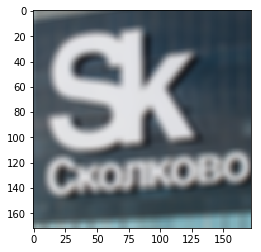

In [34]:
blurred_img, z, A = blurring(img_Sk_tiny, 9, 3)

plt.figure()
plt.imshow(np.clip(blurred_img, 0, 1))
plt.imsave("Sk_39_blur.png", np.clip(blurred_img, 0, 1))

status: optimal
error 0.199782697572
time 16.211527274666665 min


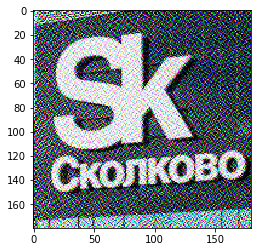

In [35]:
deblurred_img, error_img, time_img , loss_img = \
            deblurring_with_cvxpy(img_Sk_tiny, z, A,norm_value = 1, tau_value = 1e-3)

error_Sk_norm1.append(error_img)
time_Sk_norm1.append(time_img/60.0)
loss_Sk_norm1.append(loss_img)

plt.figure()
print('error', error_img)
print('time', time_img/60.0, 'min')

plt.imshow(np.clip(deblurred_img, 0, 1))
plt.imsave("Sk_39_deblur_norm1.png", np.clip(deblurred_img, 0, 1))

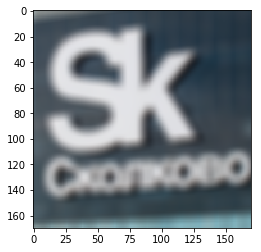

In [36]:
blurred_img, z, A = blurring(img_Sk_tiny, 11, 3)

plt.figure()
plt.imshow(np.clip(blurred_img, 0, 1))
plt.imsave("Sk_311_blur.png", np.clip(blurred_img, 0, 1))

status: optimal
error 0.23885376614
time 23.521830840888878 min


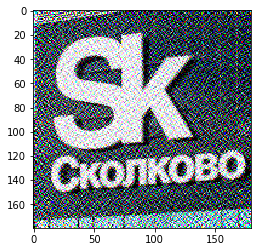

In [37]:
deblurred_img, error_img, time_img , loss_img = \
            deblurring_with_cvxpy(img_Sk_tiny, z, A,norm_value = 1, tau_value = 1e-3)

error_Sk_norm1.append(error_img)
time_Sk_norm1.append(time_img/60.0)
loss_Sk_norm1.append(loss_img)

plt.figure()
print('error', error_img)
print('time', time_img/60.0, 'min')

plt.imshow(np.clip(deblurred_img, 0, 1))
plt.imsave("Sk_311_deblur_norm1.png", np.clip(deblurred_img, 0, 1))

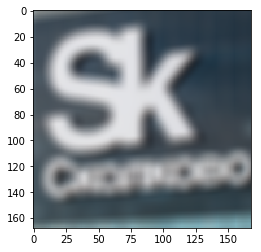

In [39]:
blurred_img, z, A = blurring(img_Sk_tiny, 13, 3)

plt.figure()
plt.imshow(np.clip(blurred_img, 0, 1))
plt.imsave("Sk_313_blur.png", np.clip(blurred_img, 0, 1))

status: optimal
error 0.274166199984
time 30.775623808 min


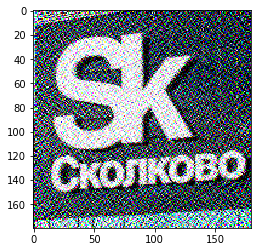

In [40]:
#1700
deblurred_img, error_img, time_img , loss_img = \
            deblurring_with_cvxpy(img_Sk_tiny, z, A,norm_value = 1, tau_value = 1e-3)

error_Sk_norm1.append(error_img)
time_Sk_norm1.append(time_img/60.0)
loss_Sk_norm1.append(loss_img)

plt.figure()
print('error', error_img)
print('time', time_img/60.0, 'min')

plt.imshow(np.clip(deblurred_img, 0, 1))
plt.imsave("Sk_313_deblur_norm1.png", np.clip(deblurred_img, 0, 1))

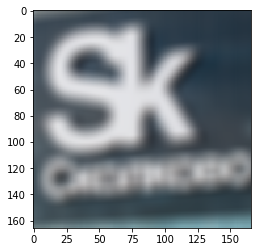

In [42]:
blurred_img, z, A = blurring(img_Sk_tiny, 15, 3)

plt.figure()
plt.imshow(np.clip(blurred_img, 0, 1))
plt.imsave("Sk_315_blur.png", np.clip(blurred_img, 0, 1))

status: optimal
error 0.305823563213
time 36.8600432711111 min


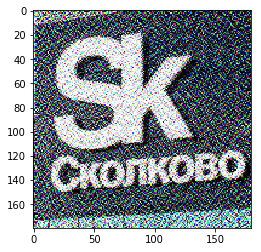

In [43]:
#1744
deblurred_img, error_img, time_img , loss_img = \
            deblurring_with_cvxpy(img_Sk_tiny, z, A,norm_value = 1, tau_value = 1e-3)

error_Sk_norm1.append(error_img)
time_Sk_norm1.append(time_img/60.0)
loss_Sk_norm1.append(loss_img) 

plt.figure()
print('error', error_img)
print('time', time_img/60.0, 'min')

plt.imshow(np.clip(deblurred_img, 0, 1))
plt.imsave("Sk_315_deblur_norm1.png", np.clip(blurred_img, 0, 1))

In [10]:
time_Sk_norm2 = []
error_Sk_norm2 = []
loss_Sk_norm2 = []

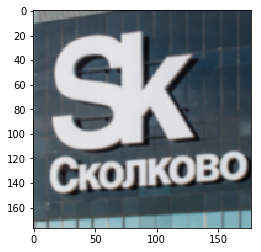

In [54]:
blurred_img, z, A = blurring(img_Sk_tiny, 4, 4)

plt.figure()
plt.imshow(np.clip(blurred_img, 0, 1))

status: optimal
error 0.05839857634
loss 5.302097411062277
time 5.38112666311111 min


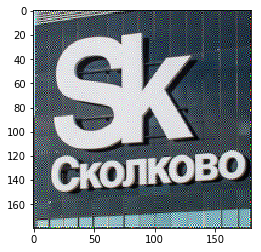

In [11]:
deblurred_img, error_img, time_img , loss_img = \
            deblurring_with_cvxpy(img_Sk_tiny, z, A,norm_value = 'fro', tau_value = 1e-3)

error_Sk_norm2.append(error_img)
time_Sk_norm2.append(time_img/60.0)
loss_Sk_norm2.append(loss_img) 

plt.figure()
print('error', error_img)
print('time', time_img/60.0, 'min')

plt.imshow(np.clip(deblurred_img, 0, 1))
plt.imsave("Sk_44_deblur_norm2.png", np.clip(deblurred_img, 0, 1))

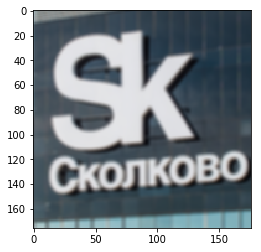

In [57]:
blurred_img, z, A = blurring(img_Sk_tiny, 5, 3)

plt.figure()
plt.imshow(np.clip(blurred_img, 0, 1))
#plt.imsave("Sk_315_blur.png", np.clip(blurred_img, 0, 1))

status: optimal
error 0.111530112329
time 5.481133646222224 min


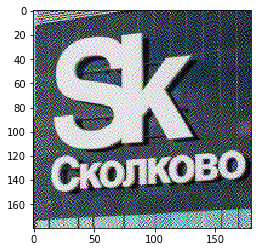

In [58]:
#19.02
deblurred_img, error_img, time_img , loss_img = \
            deblurring_with_cvxpy(img_Sk_tiny, z, A,norm_value = 'fro', tau_value = 1e-3)

error_Sk_norm2.append(error_img)
time_Sk_norm2.append(time_img/60.0)
loss_Sk_norm2.append(loss_img) 

plt.figure()
print('error', error_img)
print('time', time_img/60.0, 'min')

plt.imshow(np.clip(deblurred_img, 0, 1))
plt.imsave("Sk_35_deblur_norm2.png", np.clip(deblurred_img, 0, 1))

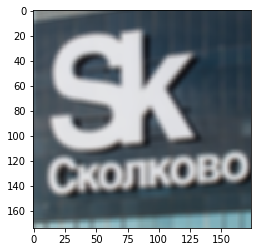

In [59]:
blurred_img, z, A = blurring(img_Sk_tiny, 7, 3)

plt.figure()
plt.imshow(np.clip(blurred_img, 0, 1))
#plt.imsave("Sk_315_blur.png", np.clip(blurred_img, 0, 1))

status: optimal
error 0.154422060255
time 8.771597276444451 min


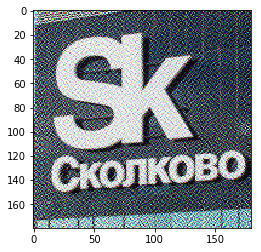

In [60]:
#19.09
deblurred_img, error_img, time_img , loss_img = \
            deblurring_with_cvxpy(img_Sk_tiny, z, A,norm_value = 'fro', tau_value = 1e-3)

error_Sk_norm2.append(error_img)
time_Sk_norm2.append(time_img/60.0)
loss_Sk_norm2.append(loss_img) 

plt.figure()
print('error', error_img)
print('time', time_img/60.0, 'min')

plt.imshow(np.clip(deblurred_img, 0, 1))
plt.imsave("Sk_37_deblur_norm2.png", np.clip(deblurred_img, 0, 1))

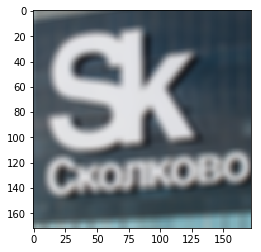

In [61]:
blurred_img, z, A = blurring(img_Sk_tiny, 9, 3)

plt.figure()
plt.imshow(np.clip(blurred_img, 0, 1))
#plt.imsave("Sk_315_blur.png", np.clip(blurred_img, 0, 1))

status: optimal
error 0.198499727827
time 15.024546183111124 min


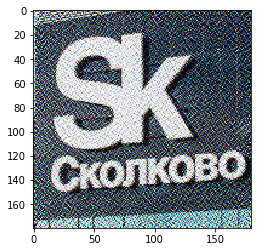

In [62]:
#19.19
deblurred_img, error_img, time_img , loss_img = \
            deblurring_with_cvxpy(img_Sk_tiny, z, A,norm_value = 'fro', tau_value = 1e-3)

error_Sk_norm2.append(error_img)
time_Sk_norm2.append(time_img/60.0)
loss_Sk_norm2.append(loss_img) 

plt.figure()
print('error', error_img)
print('time', time_img/60.0, 'min')

plt.imshow(np.clip(deblurred_img, 0, 1))
plt.imsave("Sk_39_deblur_norm2.png", np.clip(deblurred_img, 0, 1))

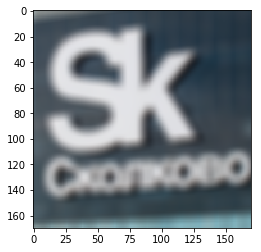

In [63]:
blurred_img, z, A = blurring(img_Sk_tiny, 11, 3)

plt.figure()
plt.imshow(np.clip(blurred_img, 0, 1))
#plt.imsave("Sk_315_blur.png", np.clip(blurred_img, 0, 1))

status: optimal
error 0.238503771065
time 16.94209713777779 min


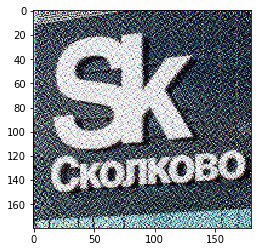

In [64]:
#19.35
deblurred_img, error_img, time_img , loss_img = \
            deblurring_with_cvxpy(img_Sk_tiny, z, A,norm_value = 'fro', tau_value = 1e-3)

error_Sk_norm2.append(error_img)
time_Sk_norm2.append(time_img/60.0)
loss_Sk_norm2.append(loss_img) 

plt.figure()
print('error', error_img)
print('time', time_img/60.0, 'min')

plt.imshow(np.clip(deblurred_img, 0, 1))
plt.imsave("Sk_311_deblur_norm2.png", np.clip(deblurred_img, 0, 1))

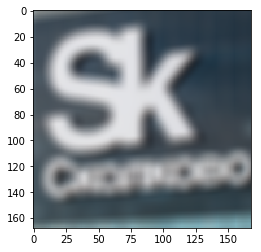

In [65]:
blurred_img, z, A = blurring(img_Sk_tiny, 13, 3)

plt.figure()
plt.imshow(np.clip(blurred_img, 0, 1))
#plt.imsave("Sk_315_blur.png", np.clip(blurred_img, 0, 1))

status: optimal
error 0.272381063516
time 30.66855459555554 min


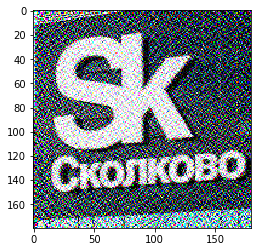

In [66]:
#19.35
deblurred_img, error_img, time_img , loss_img = \
            deblurring_with_cvxpy(img_Sk_tiny, z, A,norm_value = 'fro', tau_value = 1e-3)

error_Sk_norm2.append(error_img)
time_Sk_norm2.append(time_img/60.0)
loss_Sk_norm2.append(loss_img) 

plt.figure()
print('error', error_img)
print('time', time_img/60.0, 'min')

plt.imshow(np.clip(deblurred_img, 0, 1))
plt.imsave("Sk_313_deblur_norm2.png", np.clip(deblurred_img, 0, 1))

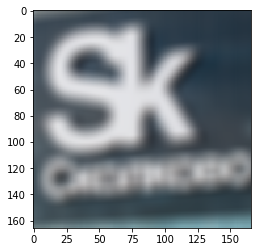

In [67]:
blurred_img, z, A = blurring(img_Sk_tiny, 15, 3)

plt.figure()
plt.imshow(np.clip(blurred_img, 0, 1))
#plt.imsave("Sk_315_blur.png", np.clip(blurred_img, 0, 1))

status: optimal
error 0.304059988284
time 41.52639291733333 min


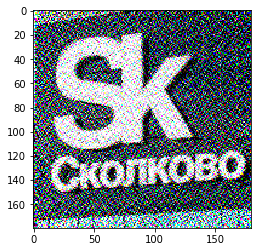

In [68]:
#20.27
deblurred_img, error_img, time_img , loss_img = \
            deblurring_with_cvxpy(img_Sk_tiny, z, A,norm_value = 'fro', tau_value = 1e-3)

error_Sk_norm2.append(error_img)
time_Sk_norm2.append(time_img/60.0)
loss_Sk_norm2.append(loss_img) 

plt.figure()
print('error', error_img)
print('time', time_img/60.0, 'min')

plt.imshow(np.clip(deblurred_img, 0, 1))
plt.imsave("Sk_315_deblur_norm2.png", np.clip(deblurred_img, 0, 1))

# Results

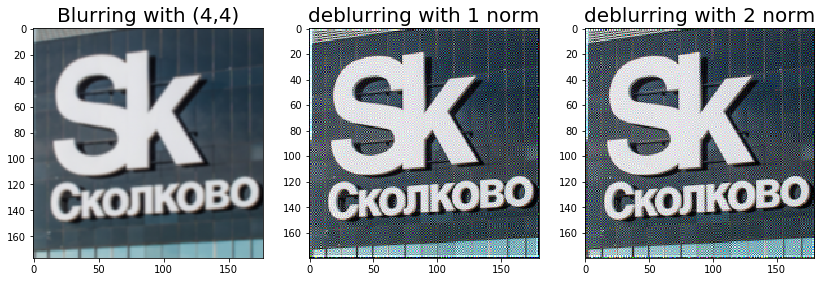

In [3]:
plt.figure(figsize=(14,6))
plt.subplot(131)
plt.title('Blurring with (4,4)', fontsize=20)
plt.imshow(plt.imread('Sk_blur_44.png'))

plt.subplot(132)
plt.title('deblurring with 1 norm', fontsize=20)
plt.imshow(plt.imread('Sk_deblur_44_norm1.png'))

plt.subplot(133)
plt.title('deblurring with 2 norm', fontsize=20)
plt.imshow(plt.imread('Sk_44_deblur_norm2.png'))
plt.show()

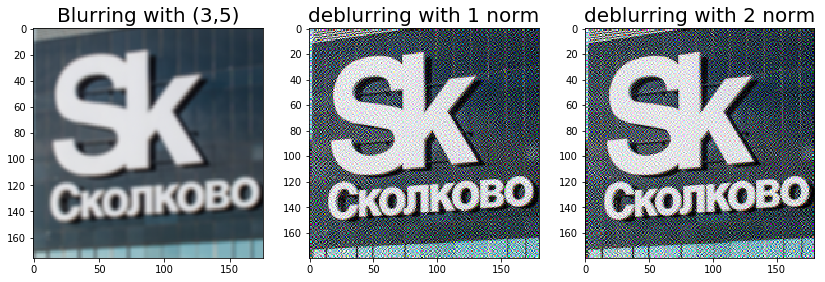

In [4]:
plt.figure(figsize=(14,6))
plt.subplot(131)
plt.title('Blurring with (3,5)', fontsize=20)
plt.imshow(plt.imread('Sk_blur_35.png'))

plt.subplot(132)
plt.title('deblurring with 1 norm', fontsize=20)
plt.imshow(plt.imread('Sk_deblur_35_norm1.png'))

plt.subplot(133)
plt.title('deblurring with 2 norm', fontsize=20)
plt.imshow(plt.imread('Sk_35_deblur_norm2.png'))
plt.show()

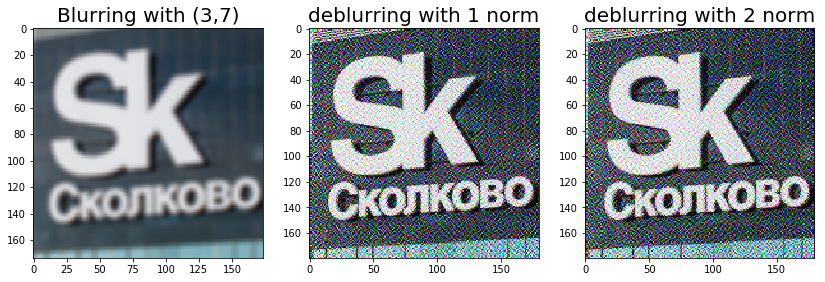

In [5]:
plt.figure(figsize=(14,6))
plt.subplot(131)
plt.title('Blurring with (3,7)', fontsize=20)
plt.imshow(plt.imread('Sk_37_blur.png'))

plt.subplot(132)
plt.title('deblurring with 1 norm', fontsize=20)
plt.imshow(plt.imread('Sk_37_deblur_norm1.png'))

plt.subplot(133)
plt.title('deblurring with 2 norm', fontsize=20)
plt.imshow(plt.imread('Sk_37_deblur_norm2.png'))
plt.show()

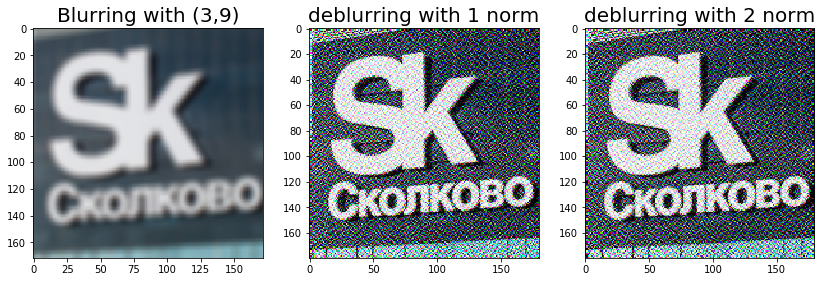

In [6]:
plt.figure(figsize=(14,6))
plt.subplot(131)
plt.title('Blurring with (3,9)', fontsize=20)
plt.imshow(plt.imread('Sk_39_blur.png'))

plt.subplot(132)
plt.title('deblurring with 1 norm', fontsize=20)
plt.imshow(plt.imread('Sk_39_deblur_norm1.png'))

plt.subplot(133)
plt.title('deblurring with 2 norm', fontsize=20)
plt.imshow(plt.imread('Sk_39_deblur_norm2.png'))
plt.show()

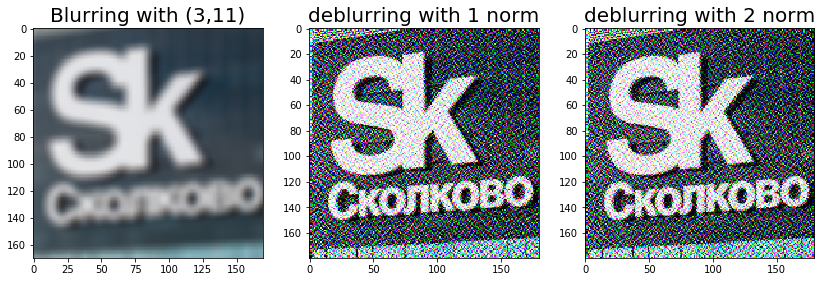

In [7]:
plt.figure(figsize=(14,6))
plt.subplot(131)
plt.title('Blurring with (3,11)', fontsize=20)
plt.imshow(plt.imread('Sk_311_blur.png'))

plt.subplot(132)
plt.title('deblurring with 1 norm', fontsize=20)
plt.imshow(plt.imread('Sk_311_deblur_norm1.png'))

plt.subplot(133)
plt.title('deblurring with 2 norm', fontsize=20)
plt.imshow(plt.imread('Sk_311_deblur_norm2.png'))
plt.show()

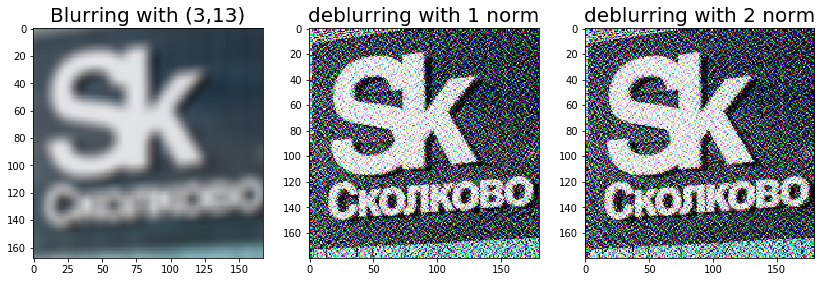

In [8]:
plt.figure(figsize=(14,6))
plt.subplot(131)
plt.title('Blurring with (3,13)', fontsize=20)
plt.imshow(plt.imread('Sk_313_blur.png'))

plt.subplot(132)
plt.title('deblurring with 1 norm', fontsize=20)
plt.imshow(plt.imread('Sk_313_deblur_norm1.png'))

plt.subplot(133)
plt.title('deblurring with 2 norm', fontsize=20)
plt.imshow(plt.imread('Sk_313_deblur_norm2.png'))
plt.show()

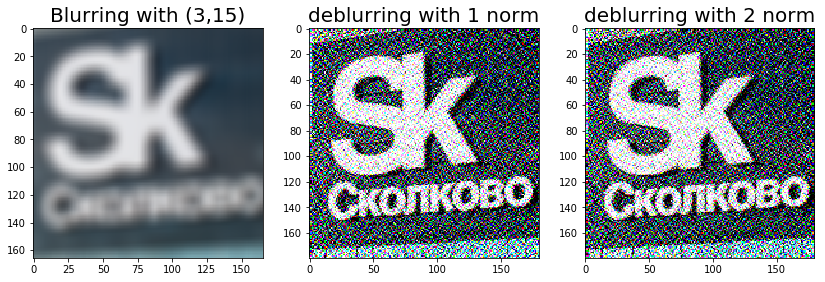

In [9]:
plt.figure(figsize=(14,6))
plt.subplot(131)
plt.title('Blurring with (3,15)', fontsize=20)
plt.imshow(plt.imread('Sk_315_blur.png'))

plt.subplot(132)
plt.title('deblurring with 1 norm', fontsize=20)
plt.imshow(plt.imread('Sk_315_deblur_norm1.png'))

plt.subplot(133)
plt.title('deblurring with 2 norm', fontsize=20)
plt.imshow(plt.imread('Sk_315_deblur_norm2.png'))
plt.show()

In [12]:
kernels = ['1:(4,4)', '2:(5,3)', '3:(7,3)', '4:(9,3)',  '5:(11,3)', '6:(13,3)',  '7:(15,3)']

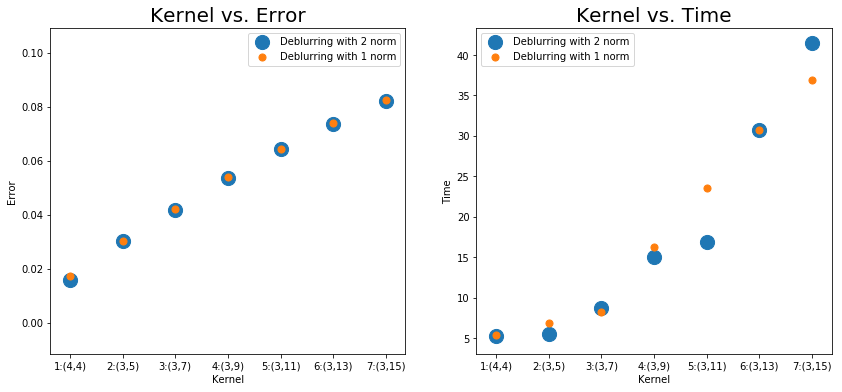

In [14]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.title('Kernel vs. Error', fontsize=20)
plt.scatter(kernels, np.array(error_Sk_norm2), s = 200, label = 'Deblurring with 2 norm')
plt.scatter(kernels, np.array(error_Sk_norm1), s = 50, label = 'Deblurring with 1 norm')
plt.ylabel("Error")
plt.xlabel("Kernel")
plt.legend()

plt.subplot(122)
plt.title('Kernel vs. Time', fontsize=20)
plt.scatter(kernels, time_Sk_norm2, s = 200, label = 'Deblurring with 2 norm')
plt.scatter(kernels, time_Sk_norm1, s = 50, label = 'Deblurring with 1 norm')
plt.legend()
plt.ylabel("Time")
plt.xlabel("Kernel")

plt.show()

